In [104]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import os
%matplotlib inline

## 5. Configuración: fase y modelos a comparar


En esta sección definimos la fase y los modelos para cargar múltiples `scores.npz` y visualizar los resultados de forma comparativa.

In [168]:
# Definir fase y modelos a comparar
selected_phase_name = 'fase4'
models_by_phase = {
    'fase1': [
        'swinv2_tiny_window16_256',
        'vit_base_patch32_224',
        'vit_small_patch14_reg4_dinov2'
    ],
    'fase3': [
        '../fase1/swinv2_tiny_window16_256',
        'swinv2_small_window16_256',
        'swinv2_base_window16_256',
        'swinv2_large_window12_192',
        
    ],
    'fase2': [
        '../fase1/swinv2_tiny_window16_256',
        'swinv2_tiny_window8_256'
    ],
    'fase4': [
        '../fase3/swinv2_base_window16_256'
        ]

}
selected_models = models_by_phase[selected_phase_name]


print(f"Fase seleccionada: {selected_phase_name}")
print(f"Modelos seleccionados: {selected_models}")

Fase seleccionada: fase4
Modelos seleccionados: ['../fase3/swinv2_base_window16_256']


In [169]:
# Utilidades: carga de scores y cálculo de D′ (d-prime)
def load_score_bundle(phase: str, model: str):
    path = os.path.join('outputs_pth', phase, model, 'scores.npz')
    if not os.path.exists(path):
        raise FileNotFoundError(f"No se encontró {path}")
    data = np.load(path, allow_pickle=True)
    scores = data['scores']
    labels = data['labels']
    norm_scores = data['norm_scores']
    binary_sigmoid = data['binary_sigmoid'] if 'binary_sigmoid' in data else False
    effective_classes = int(data['effective_classes']) if 'effective_classes' in data else scores.shape[1]
    return {
        'scores': scores,
        'labels': labels,
        'norm_scores': norm_scores,
        'binary_sigmoid': bool(binary_sigmoid),
        'effective_classes': int(effective_classes)
    }

def d_prime_from_scores(scores_vec: np.ndarray, labels_bin: np.ndarray):
    # labels_bin: 1 para positivos (clase objetivo), 0 para negativos (resto)
    pos = scores_vec[labels_bin == 1]
    neg = scores_vec[labels_bin == 0]
    if pos.size == 0 or neg.size == 0:
        return np.nan, np.nan, np.nan
    mu_pos = float(np.mean(pos))
    mu_neg = float(np.mean(neg))
    std_pos = float(np.std(pos, ddof=1)) if pos.size > 1 else 0.0
    std_neg = float(np.std(neg, ddof=1)) if neg.size > 1 else 0.0
    # Pooled std (SDT convencional)
    pooled = np.sqrt(0.5 * (std_pos**2 + std_neg**2))
    if pooled == 0:
        return np.nan, mu_pos, mu_neg
    dprime = (mu_pos - mu_neg) / pooled
    return dprime, mu_pos, mu_neg

def compute_dprime(scores: np.ndarray, labels: np.ndarray, effective_classes: int, binary_sigmoid: bool):
    rows = []
    if effective_classes == 1 or binary_sigmoid:
        # Binario: usar columna 0 como positiva (clase 1) vs negativa (clase 0)
        labels_bin = labels.astype(int)
        d, mu_pos, mu_neg = d_prime_from_scores(scores[:, 0], labels_bin)
        rows.append({'clase': '1 (binaria)', 'd_prime': d, 'mu_pos': mu_pos, 'mu_neg': mu_neg})
    else:
        # Multiclase: one-vs-rest para cada clase
        for k in range(scores.shape[1]):
            labels_bin = (labels == k).astype(int)
            d, mu_pos, mu_neg = d_prime_from_scores(scores[:, k], labels_bin)
            rows.append({'clase': f'{k}', 'd_prime': d, 'mu_pos': mu_pos, 'mu_neg': mu_neg})
    if pd is not None:
        df = pd.DataFrame(rows)
        return df
    else:
        return rows

In [170]:
import numpy as np
from typing import List, Dict, Tuple, Optional

def _safe_div(n: float, d: float) -> float:
    return n / d if d != 0 else 0.0

def threshold_analysis(
    y_true: np.ndarray,
    y_score: np.ndarray,
    thresholds: Optional[np.ndarray] = None,
    pos_label: int = 1,
    criterion: str = "youden"
) -> Tuple[List[Dict[str, float]], float, Dict[str, float]]:
    """
    Analiza métricas de clasificación binaria a través de distintos umbrales.

    Parámetros:
      y_true: etiquetas reales (0/1).
      y_score: scores o probabilidades del modelo en [0,1].
      thresholds: array de umbrales a evaluar; si None usa np.linspace(0,1,101).
      pos_label: etiqueta positiva.
      criterion: 'youden' | 'f1' | 'accuracy' | 'balanced_accuracy' para seleccionar umbral óptimo.

    Retorna:
      metrics_list: lista de dicts con métricas por umbral.
      best_threshold: umbral óptimo según el criterio.
      best_metrics: dict de métricas del umbral óptimo.
    """
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)

    if thresholds is None:
        thresholds = np.linspace(0.0, 1.0, 101)
    else:
        thresholds = np.asarray(thresholds)

    metrics_list: List[Dict[str, float]] = []

    pos = pos_label
    neg = 1 - pos_label

    for t in thresholds:
        y_pred = (y_score >= t).astype(int)

        tp = int(np.sum((y_true == pos) & (y_pred == 1)))
        fp = int(np.sum((y_true == neg) & (y_pred == 1)))
        tn = int(np.sum((y_true == neg) & (y_pred == 0)))
        fn = int(np.sum((y_true == pos) & (y_pred == 0)))

        precision = _safe_div(tp, tp + fp)
        recall = _safe_div(tp, tp + fn)             # sensibilidad
        specificity = _safe_div(tn, tn + fp)
        accuracy = _safe_div(tp + tn, tp + tn + fp + fn)
        f1 = _safe_div(2 * precision * recall, precision + recall)
        balanced_accuracy = (recall + specificity) / 2.0
        youden_j = recall + specificity - 1.0

        mcc_num = tp * tn - fp * fn
        mcc_den = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        mcc = _safe_div(mcc_num, mcc_den)

        metrics_list.append({
            "threshold": float(t),
            "tp": tp, "fp": fp, "tn": tn, "fn": fn,
            "precision": precision,
            "recall": recall,
            "specificity": specificity,
            "accuracy": accuracy,
            "f1": f1,
            "balanced_accuracy": balanced_accuracy,
            "youden_j": youden_j,
            "mcc": mcc,
        })

    # Selección de umbral óptimo
    key_map = {
        "youden": "youden_j",
        "f1": "f1",
        "accuracy": "accuracy",
        "balanced_accuracy": "balanced_accuracy",
    }
    metric_key = key_map.get(criterion, "youden_j")

    values = np.array([m[metric_key] for m in metrics_list])
    best_idx = int(np.argmax(values))
    best_metrics = metrics_list[best_idx]
    best_threshold = best_metrics["threshold"]

    return metrics_list, best_threshold, best_metrics

# Ejemplo de uso:
# metrics, t_opt, best = threshold_analysis(y_true, y_prob, criterion="youden")
# print("Umbral óptimo:", t_opt)
# print("Métricas en óptimo:", best)

In [171]:
# Confusión: matrices por modelo, mostradas juntas
from sklearn.metrics import accuracy_score

def plot_confusions_for_models(phase: str, models: list):
    n = len(models)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
    if n == 1:
        axes = [axes]

    for ax, model in zip(axes, models):
        bundle = load_score_bundle(phase, model)
        scores = bundle['scores']
        labels = bundle['labels']
        binary_sigmoid = bundle['binary_sigmoid']
        effective_classes = bundle['effective_classes']

        if effective_classes == 1 or binary_sigmoid:
            preds = (scores[:, 0] >= 0.5).astype(int)
        else:
            preds = np.argmax(scores, axis=1)

        cm = confusion_matrix(labels, preds)
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        cm_pct = (cm / row_sums) * 100.0

        # Etiquetas de ejes
        if effective_classes == 1 or binary_sigmoid:
            class_names = ['benign 0', 'maligno 1']
        else:
            class_names = [f'Clase {k}' for k in range(cm.shape[0])]

        # Anotaciones: conteos y porcentajes
        annot = np.empty_like(cm, dtype=object)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                annot[i, j] = f"{cm[i, j]}\n{cm_pct[i, j]:.1f}%"

        sns.heatmap(
            cm_pct,
            annot=annot,
            fmt="",
            cmap='Blues',
            cbar=False,
            ax=ax,
            xticklabels=class_names,
            yticklabels=class_names,
        )

        ax.set_title(f'{model}\nAcc: {accuracy_score(labels, preds):.4f}')
        ax.set_xlabel('Predicción')
        ax.set_ylabel('Real')
        ax.set_xticklabels(class_names, rotation=0)
        ax.set_yticklabels(class_names, rotation=0)

    plt.tight_layout()
    plt.show()

In [172]:
# Curvas ROC: una figura con los 3 modelos
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
def _stable_softmax(x: np.ndarray, axis: int = 1) -> np.ndarray:
    x_max = np.max(x, axis=axis, keepdims=True)
    e = np.exp(x - x_max)
    return e / np.sum(e, axis=axis, keepdims=True)
def _sigmoid(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))
def plot_roc_for_models(phase: str, models: list, use_norm_scores: bool = True):
    plt.figure(figsize=(8, 6))
    for model in models:
        bundle = load_score_bundle(phase, model)
        scores = bundle['scores']
        labels = bundle['labels']
        norm_scores = bundle['norm_scores']
        binary_sigmoid = bundle['binary_sigmoid']
        effective_classes = bundle['effective_classes']
        # Elegir probabilidades
        if use_norm_scores and norm_scores is not None and norm_scores.shape == scores.shape:
            probs = norm_scores
        else:
            if effective_classes == 1 or binary_sigmoid:
                probs = _sigmoid(scores) if scores.ndim == 1 else _sigmoid(scores[:, 0:1])
            else:
                probs = _stable_softmax(scores, axis=1)
        # Binario vs multiclase
        if effective_classes == 1 or binary_sigmoid:
            y_true = labels.astype(int)
            y_score = probs[:, 0] if probs.ndim == 2 else probs
            # Validar presencia de ambas clases
            if len(np.unique(y_true)) < 2:
                print(f"Aviso: {model} no tiene ambas clases presentes. Se omite ROC.")
                continue
            fpr, tpr, _ = roc_curve(y_true, y_score)
            auc_val = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f"{model} (AUC={auc_val:.3f})")
        else:
            n_classes = scores.shape[1]
            classes = list(range(n_classes))
            y_true_bin = label_binarize(labels, classes=classes)
            # Algunas clases pueden no aparecer; calcular macro-promedio sobre las válidas
            fpr_grid = np.linspace(0, 1, 101)
            tprs = []
            valid = 0
            for k in range(n_classes):
                yk = y_true_bin[:, k]
                if yk.sum() == 0 or (yk.size - yk.sum()) == 0:
                    continue
                fpr_k, tpr_k, _ = roc_curve(yk, probs[:, k])
                tpr_interp = np.interp(fpr_grid, fpr_k, tpr_k)
                tpr_interp[0] = 0.0
                tprs.append(tpr_interp)
                valid += 1
            if valid == 0:
                print(f"Aviso: {model} no tiene clases suficientes para ROC multiclase. Se omite.")
                continue
            mean_tpr = np.mean(np.vstack(tprs), axis=0)
            mean_tpr[-1] = 1.0
            auc_val = auc(fpr_grid, mean_tpr)
            plt.plot(fpr_grid, mean_tpr, lw=2, label=f"{model} (macro AUC={auc_val:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Azar')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR (1 - Especificidad)')
    plt.ylabel('TPR (Sensibilidad)')
    plt.title('Curvas ROC por modelo (una figura)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


===== ../fase3/swinv2_base_window16_256 — Classification Report =====
              precision    recall  f1-score   support

     Clase 0     0.9825    0.8961    0.9373     15067
     Clase 1     0.5374    0.8834    0.6683      2058

    accuracy                         0.8946     17125
   macro avg     0.7600    0.8898    0.8028     17125
weighted avg     0.9290    0.8946    0.9050     17125



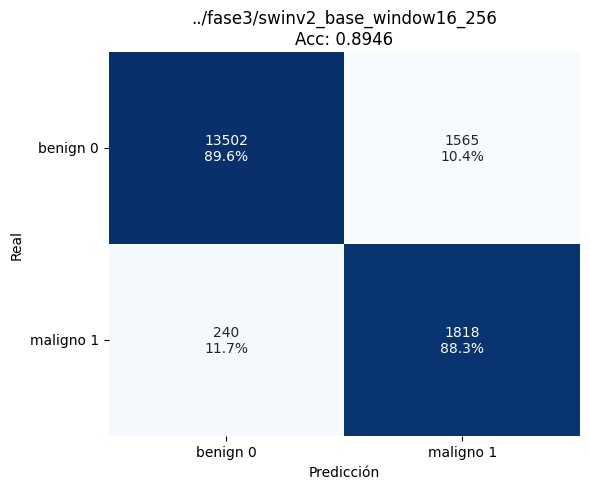


===== ../fase3/swinv2_base_window16_256 — Classification Report =====
              precision    recall  f1-score   support

     Clase 0     0.9825    0.8961    0.9373     15067
     Clase 1     0.5374    0.8834    0.6683      2058

    accuracy                         0.8946     17125
   macro avg     0.7600    0.8898    0.8028     17125
weighted avg     0.9290    0.8946    0.9050     17125



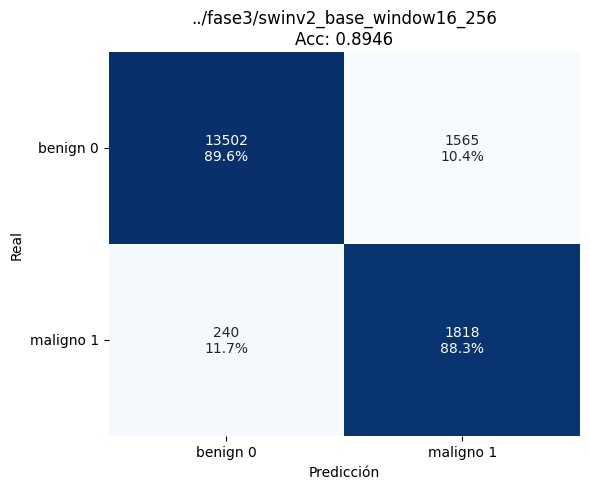

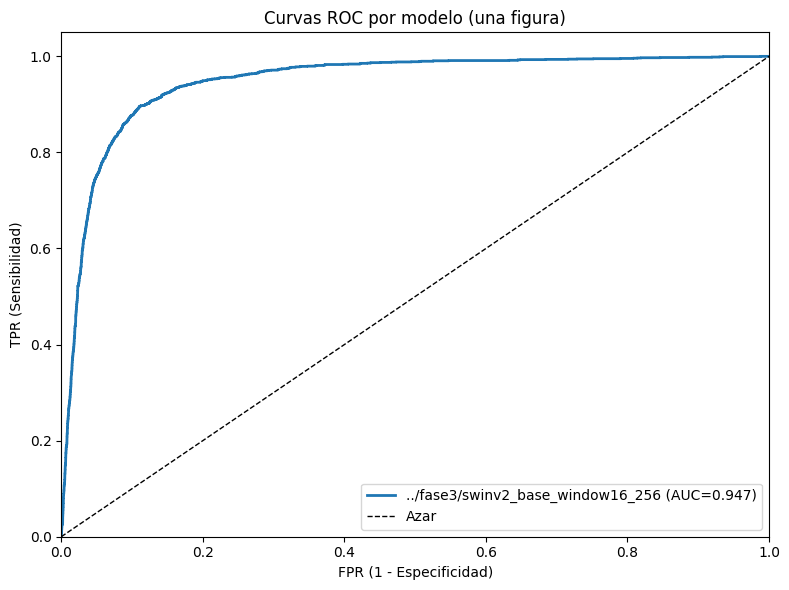


Tabla D-prime (separabilidad de scores) por modelo y clase:


,modelo,clase,d_prime,mu_pos,mu_neg
0,../fase3/swinv2_base_window16_256,1 (binaria),2.663974,0.862491,0.110941


In [173]:
# Ejecución simplificada: solo matrices de confusión, D′, Classification Report y ROC
from sklearn.metrics import classification_report

all_dprime_rows = []
for model in selected_models:
    bundle = load_score_bundle(selected_phase_name, model)
    scores = bundle['scores']
    labels = bundle['labels']
    binary_sigmoid = bundle['binary_sigmoid']
    effective_classes = bundle['effective_classes']

    # Predicciones por modelo
    if effective_classes == 1 or binary_sigmoid:
        preds = (scores[:, 0] >= 0.5).astype(int)
        target_names = ['Clase 0', 'Clase 1']
    else:
        preds = np.argmax(scores, axis=1)
        target_names = [f'Clase {k}' for k in range(scores.shape[1])]

    # Classification Report
    print(f"\n===== {model} — Classification Report =====")
    print(classification_report(labels, preds, target_names=target_names, digits=4))

    # D′ por clase para este modelo
    df_d = compute_dprime(scores, labels, effective_classes, binary_sigmoid)
    if pd is not None:
        df_d['modelo'] = model
    else:
        for r in df_d:
            r['modelo'] = model
    all_dprime_rows.append(df_d)

# Matrices de confusión para todos los modelos juntos
plot_confusions_for_models(selected_phase_name, selected_models)

# Curvas ROC (una figura con los 3 modelos)
plot_roc_for_models(selected_phase_name, selected_models)

# Tabla consolidada de D′
if pd is not None:
    df_dprime_all = pd.concat(all_dprime_rows, ignore_index=True)
    df_dprime_all = df_dprime_all[['modelo', 'clase', 'd_prime', 'mu_pos', 'mu_neg']]
    print('\nTabla D-prime (separabilidad de scores) por modelo y clase:')
    display(df_dprime_all)
else:
    print('\nTabla D-prime (lista) - instale pandas para verla como DataFrame:')
    rows = []
    for df_or_rows in all_dprime_rows:
        rows.extend(df_or_rows)
    for r in rows:
        dval = r['d_prime']
        dtxt = f"{dval:.4f}" if not np.isnan(dval) else 'nan'
        print(f"Modelo={r['modelo']} | Clase={r['clase']} | d'={dtxt} | mu_pos={r['mu_pos']:.4f} | mu_neg={r['mu_neg']:.4f}")

## Visualización del umbral óptimo por modelo
Este apartado calcula el umbral óptimo (criterio de Youden por defecto) para cada modelo seleccionado y grafica las métricas en función del umbral, indicando el óptimo con una línea vertical.


===== ../fase3/swinv2_base_window16_256 — Umbral óptimo (Youden): 0.370 =====
{'threshold': '0.3700', 'tp': 1843, 'fp': 1665, 'tn': 13402, 'fn': 215, 'precision': '0.5254', 'recall': '0.8955', 'specificity': '0.8895', 'accuracy': '0.8902', 'f1': '0.6622', 'balanced_accuracy': '0.8925', 'youden_j': '0.7850', 'mcc': '0.6325'}


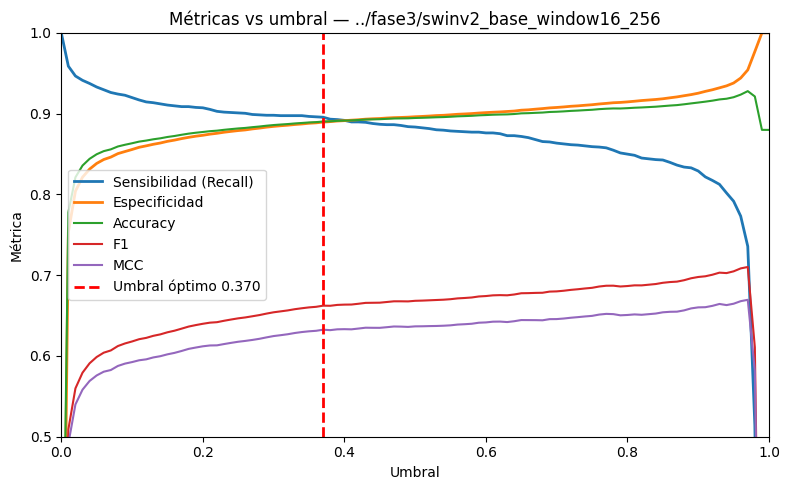

In [180]:
# Demo: cálculo y visualización del umbral óptimo por modelo
def _ensure_binary_probs(scores: np.ndarray, norm_scores: np.ndarray, binary_sigmoid: bool, effective_classes: int) -> np.ndarray:
    # Genera probabilidades binarias en [0,1] para la clase positiva
    def _stable_softmax(x: np.ndarray, axis: int = 1) -> np.ndarray:
        x_max = np.max(x, axis=axis, keepdims=True)
        e = np.exp(x - x_max)
        return e / np.sum(e, axis=axis, keepdims=True)
    def _sigmoid(x: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-x))
    if effective_classes == 1 or binary_sigmoid:
        if norm_scores is not None and norm_scores.shape == scores.shape:
            return norm_scores[:, 0] if norm_scores.ndim == 2 else norm_scores
        else:
            return _sigmoid(scores[:, 0]) if scores.ndim == 2 else _sigmoid(scores)
    else:
        # Multiclase: opción por defecto clase 1 como positiva (one-vs-rest)
        if norm_scores is not None and norm_scores.shape == scores.shape:
            return norm_scores[:, 1]
        else:
            return _stable_softmax(scores, axis=1)[:, 1]

for model in selected_models:
    bundle = load_score_bundle(selected_phase_name, model)
    scores = bundle['scores']
    labels = bundle['labels']
    norm_scores = bundle['norm_scores']
    binary_sigmoid = bundle['binary_sigmoid']
    effective_classes = bundle['effective_classes']
    
    # Binarización de etiquetas para análisis de umbral
    if effective_classes == 1 or binary_sigmoid:
        y_true = labels.astype(int)
    else:
        y_true = (labels == 1).astype(int)  # one-vs-rest para clase 1
    
    y_prob = _ensure_binary_probs(scores, norm_scores, binary_sigmoid, effective_classes)
    
    metrics_list, t_opt, best = threshold_analysis(y_true, y_prob, criterion="youden")
    print(f"\n===== {model} — Umbral óptimo (Youden): {t_opt:.3f} =====")
    print({k: (f"{v:.4f}" if isinstance(v, float) else v) for k, v in best.items()})
    
    # Visualización de métricas vs umbral
    thr = np.array([m['threshold'] for m in metrics_list])
    recall = np.array([m['recall'] for m in metrics_list])
    specificity = np.array([m['specificity'] for m in metrics_list])
    accuracy = np.array([m['accuracy'] for m in metrics_list])
    f1 = np.array([m['f1'] for m in metrics_list])
    mcc = np.array([m['mcc'] for m in metrics_list])
    
    plt.figure(figsize=(8, 5))
    plt.plot(thr, recall, label='Sensibilidad (Recall)', lw=2)
    plt.plot(thr, specificity, label='Especificidad', lw=2)
    plt.plot(thr, accuracy, label='Accuracy', lw=1.5)
    plt.plot(thr, f1, label='F1', lw=1.5)
    plt.plot(thr, mcc, label='MCC', lw=1.5)
    plt.axvline(t_opt, color='red', ls='--', lw=2, label=f"Umbral óptimo {t_opt:.3f}")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.5, 1.0)
    plt.xlabel('Umbral')
    plt.ylabel('Métrica')
    plt.title(f'Métricas vs umbral — {model}')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

## Matrices de confusión con umbrales óptimos
Calcula el umbral óptimo por modelo (criterio seleccionable) y muestra las matrices de confusión usando esos umbrales.

Criterio de umbral seleccionado: youden

===== ../fase3/swinv2_base_window16_256 — Classification Report (umbral óptimo) =====
              precision    recall  f1-score   support

     Clase 0     0.9842    0.8895    0.9345     15067
     Clase 1     0.5254    0.8955    0.6622      2058

    accuracy                         0.8902     17125
   macro avg     0.7548    0.8925    0.7983     17125
weighted avg     0.9291    0.8902    0.9017     17125



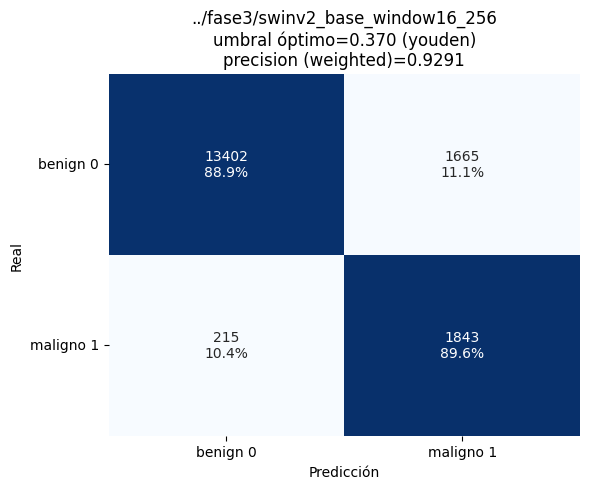

In [181]:
# Selección de criterio y visualización de confusiones con umbral óptimo
opt_criterion = "youden"  # opciones: "youden", "f1", "accuracy", "balanced_accuracy"

from sklearn.metrics import classification_report

def _ensure_binary_probs(scores: np.ndarray, norm_scores: np.ndarray, binary_sigmoid: bool, effective_classes: int) -> np.ndarray:
    def _stable_softmax(x: np.ndarray, axis: int = 1) -> np.ndarray:
        x_max = np.max(x, axis=axis, keepdims=True)
        e = np.exp(x - x_max)
        return e / np.sum(e, axis=axis, keepdims=True)
    def _sigmoid(x: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-x))
    if effective_classes == 1 or binary_sigmoid:
        if norm_scores is not None and norm_scores.shape == scores.shape:
            return norm_scores[:, 0] if norm_scores.ndim == 2 else norm_scores
        else:
            return _sigmoid(scores[:, 0]) if scores.ndim == 2 else _sigmoid(scores)
    else:
        # Multiclase: por defecto usar clase 1 como positiva (one-vs-rest)
        if norm_scores is not None and norm_scores.shape == scores.shape:
            return norm_scores[:, 1]
        else:
            return _stable_softmax(scores, axis=1)[:, 1]

def plot_confusions_with_best_thresholds(phase: str, models: list, criterion: str = "youden"):
    n = len(models)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
    if n == 1:
        axes = [axes]
    
    for ax, model in zip(axes, models):
        bundle = load_score_bundle(phase, model)
        scores = bundle['scores']
        labels = bundle['labels']
        norm_scores = bundle['norm_scores']
        binary_sigmoid = bundle['binary_sigmoid']
        effective_classes = bundle['effective_classes']
        
        # Solo umbralizamos si es binario; si multiclase, usar argmax
        if effective_classes == 1 or binary_sigmoid:
            y_true = labels.astype(int)
            y_prob = _ensure_binary_probs(scores, norm_scores, binary_sigmoid, effective_classes)
            metrics_list, t_opt, best = threshold_analysis(y_true, y_prob, criterion=criterion)
            y_pred = (y_prob >= t_opt).astype(int)
            class_names = ['benign 0', 'maligno 1']
            target_names = ['Clase 0', 'Clase 1']
            # Classification Report (string) y dict para weighted avg
            report_str = classification_report(y_true, y_pred, target_names=target_names, digits=4)
            report_dict = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
            weighted_precision = float(report_dict.get('weighted avg', {}).get('precision', float('nan')))
            print(f"\n===== {model} — Classification Report (umbral óptimo) =====")
            print(report_str)
            title_suffix = f"umbral óptimo={t_opt:.3f} ({criterion})\nprecision (weighted)={weighted_precision:.4f}"
        else:
            y_pred = np.argmax(scores, axis=1)
            y_true = labels
            class_names = [f'Clase {k}' for k in range(scores.shape[1])]
            target_names = [f'Clase {k}' for k in range(scores.shape[1])]
            # Classification Report (string) y dict para weighted avg
            report_str = classification_report(y_true, y_pred, target_names=target_names, digits=4)
            report_dict = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
            weighted_precision = float(report_dict.get('weighted avg', {}).get('precision', float('nan')))
            print(f"\n===== {model} — Classification Report (argmax) =====")
            print(report_str)
            title_suffix = f"multiclase (argmax)\nprecision (weighted)={weighted_precision:.4f}"
        
        cm = confusion_matrix(y_true, y_pred)
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1
        cm_pct = (cm / row_sums) * 100.0
        
        annot = np.empty_like(cm, dtype=object)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                annot[i, j] = f"{cm[i, j]}\n{cm_pct[i, j]:.1f}%"
        
        sns.heatmap(
            cm_pct,
            annot=annot,
            fmt="",
            cmap='Blues',
            cbar=False,
            ax=ax,
            xticklabels=class_names,
            yticklabels=class_names,
        )
        ax.set_title(f"{model}\n{title_suffix}")
        ax.set_xlabel('Predicción')
        ax.set_ylabel('Real')
        ax.set_xticklabels(class_names, rotation=0)
        ax.set_yticklabels(class_names, rotation=0)
    
    plt.tight_layout()
    plt.show()

print(f"Criterio de umbral seleccionado: {opt_criterion}")
plot_confusions_with_best_thresholds(selected_phase_name, selected_models, criterion=opt_criterion)